In [1]:
# This Colab requires a recent numpy version.
#pip install numpy
#pip install protobuf==3.20.3

In [2]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

/tmp/ipykernel_1338210/3191803482.py:8: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc
2025-08-15 22:24:03.061112: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-15 22:24:03.061694: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-15 22:24:03.064234: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-15 22:24:03.070168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755276843.079336 1338210 cuda_dnn.cc:8579] Unable to 

# Utilities

In [3]:
# @title Run this!!

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]


# Visualization tools

In [4]:
# Clone the tensorflow models repository
#!git clone --depth 1 https://github.com/tensorflow/models

In [5]:
# Installing the Object Detection API
#sudo apt install -y protobuf-compiler
#cd models/research/
#protoc object_detection/protos/*.proto --python_out=.
#cp object_detection/packages/tf2/setup.py .
#python -m pip install .

In [6]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

# Load label map data (for plotting).

In [7]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


In [8]:
model_display_name = 'CenterNet HourGlass104 Keypoints 512x512' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:CenterNet HourGlass104 Keypoints 512x512
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1


# Loading the selected model from TensorFlow Hub

In [9]:
"""
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')
"""

"\nprint('loading model...')\nhub_model = hub.load(model_handle)\nprint('model loaded!')\n"

In [10]:
import pickle


In [11]:
# save the model
#filename = 'object_detection.sav'
#pickle.dump(hub_model, open(filename, 'wb'))

In [12]:
import joblib

In [13]:
# save the model
#filename = 'object_detection.sav'
#joblib.dump(hub_model, open(filename, 'wb'))

In [14]:
#export_module_dir = os.path.join(os.getcwd(), "finetuned_model_export")
#tf.saved_model.save(hub_model, export_module_dir)

In [15]:
# load the model
import_module_dir = os.path.join(os.getcwd(), "finetuned_model_export")

model=tf.saved_model.load(import_module_dir)
hub_model=tf.saved_model.load(import_module_dir)

2025-08-15 22:24:22.929976: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


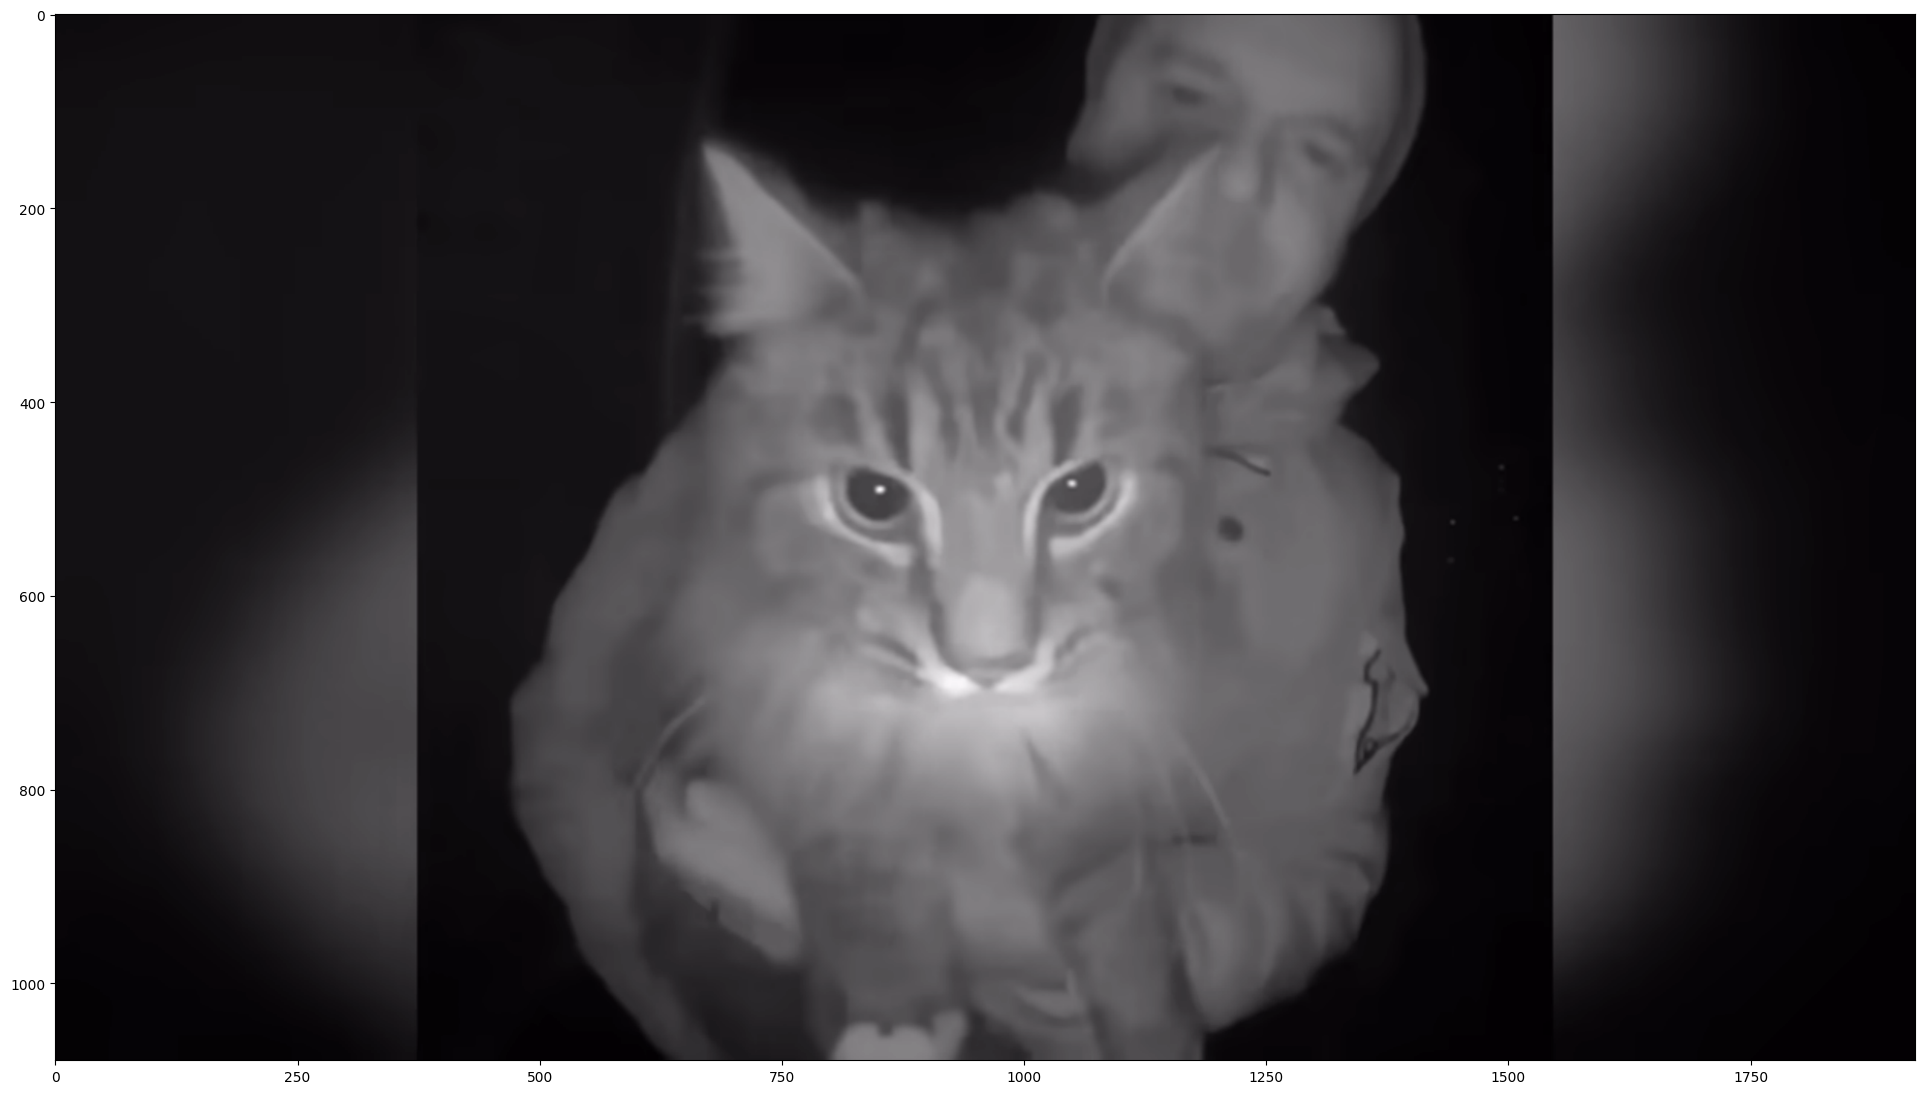

In [31]:
selected_image = 'Beach' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False
convert_image_to_grayscale = False

#image_path = IMAGES_FOR_TEST[selected_image]
#image_path= './.screenshots/192_168_122_201_3717735360_2025_08_10_08_28_33.png'
image_path= './.screenshots/192_168_122_201_7421146506_2025_08_10_20_32_18.png'
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()


In [32]:
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['detection_boxes', 'detection_classes', 'detection_keypoint_scores', 'detection_keypoints', 'detection_scores', 'num_detections'])


# Visualizing the results

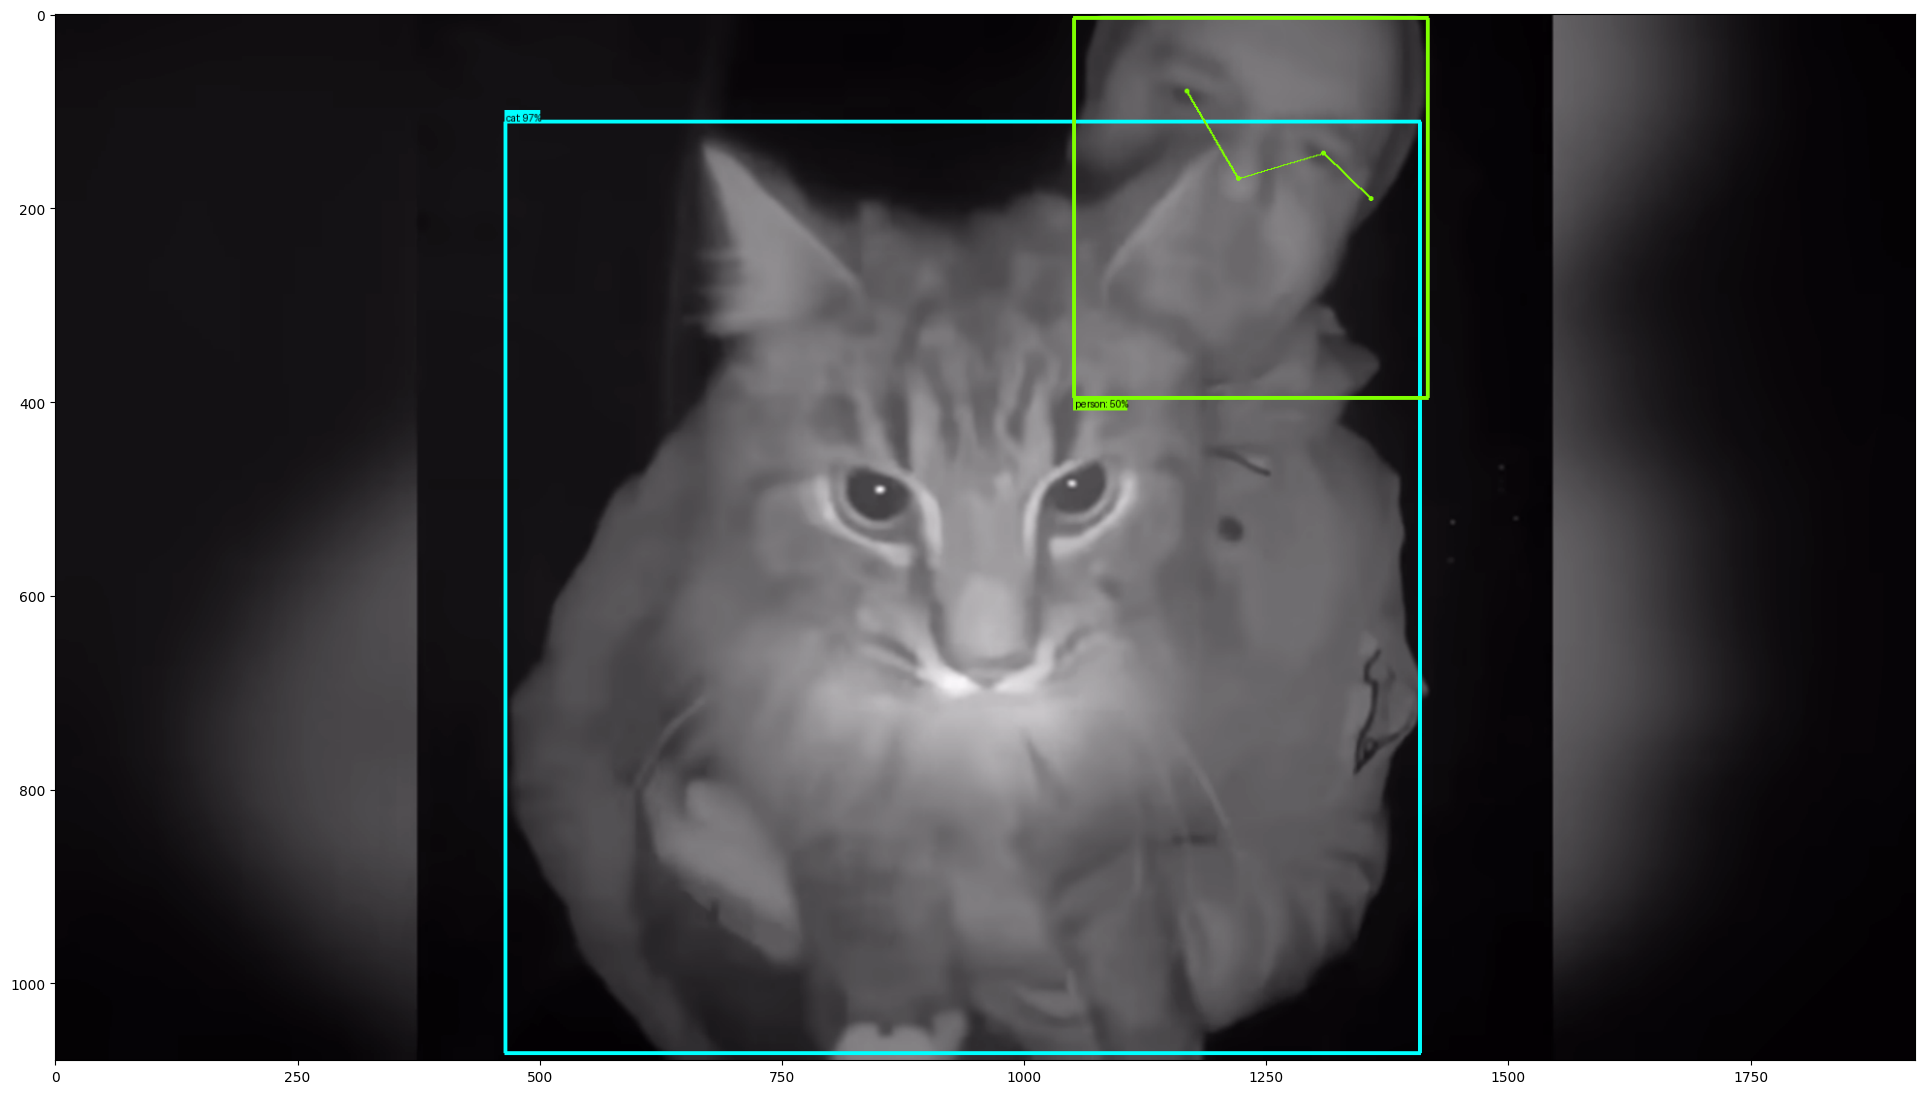

In [33]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]
    
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

{'cat': 1}


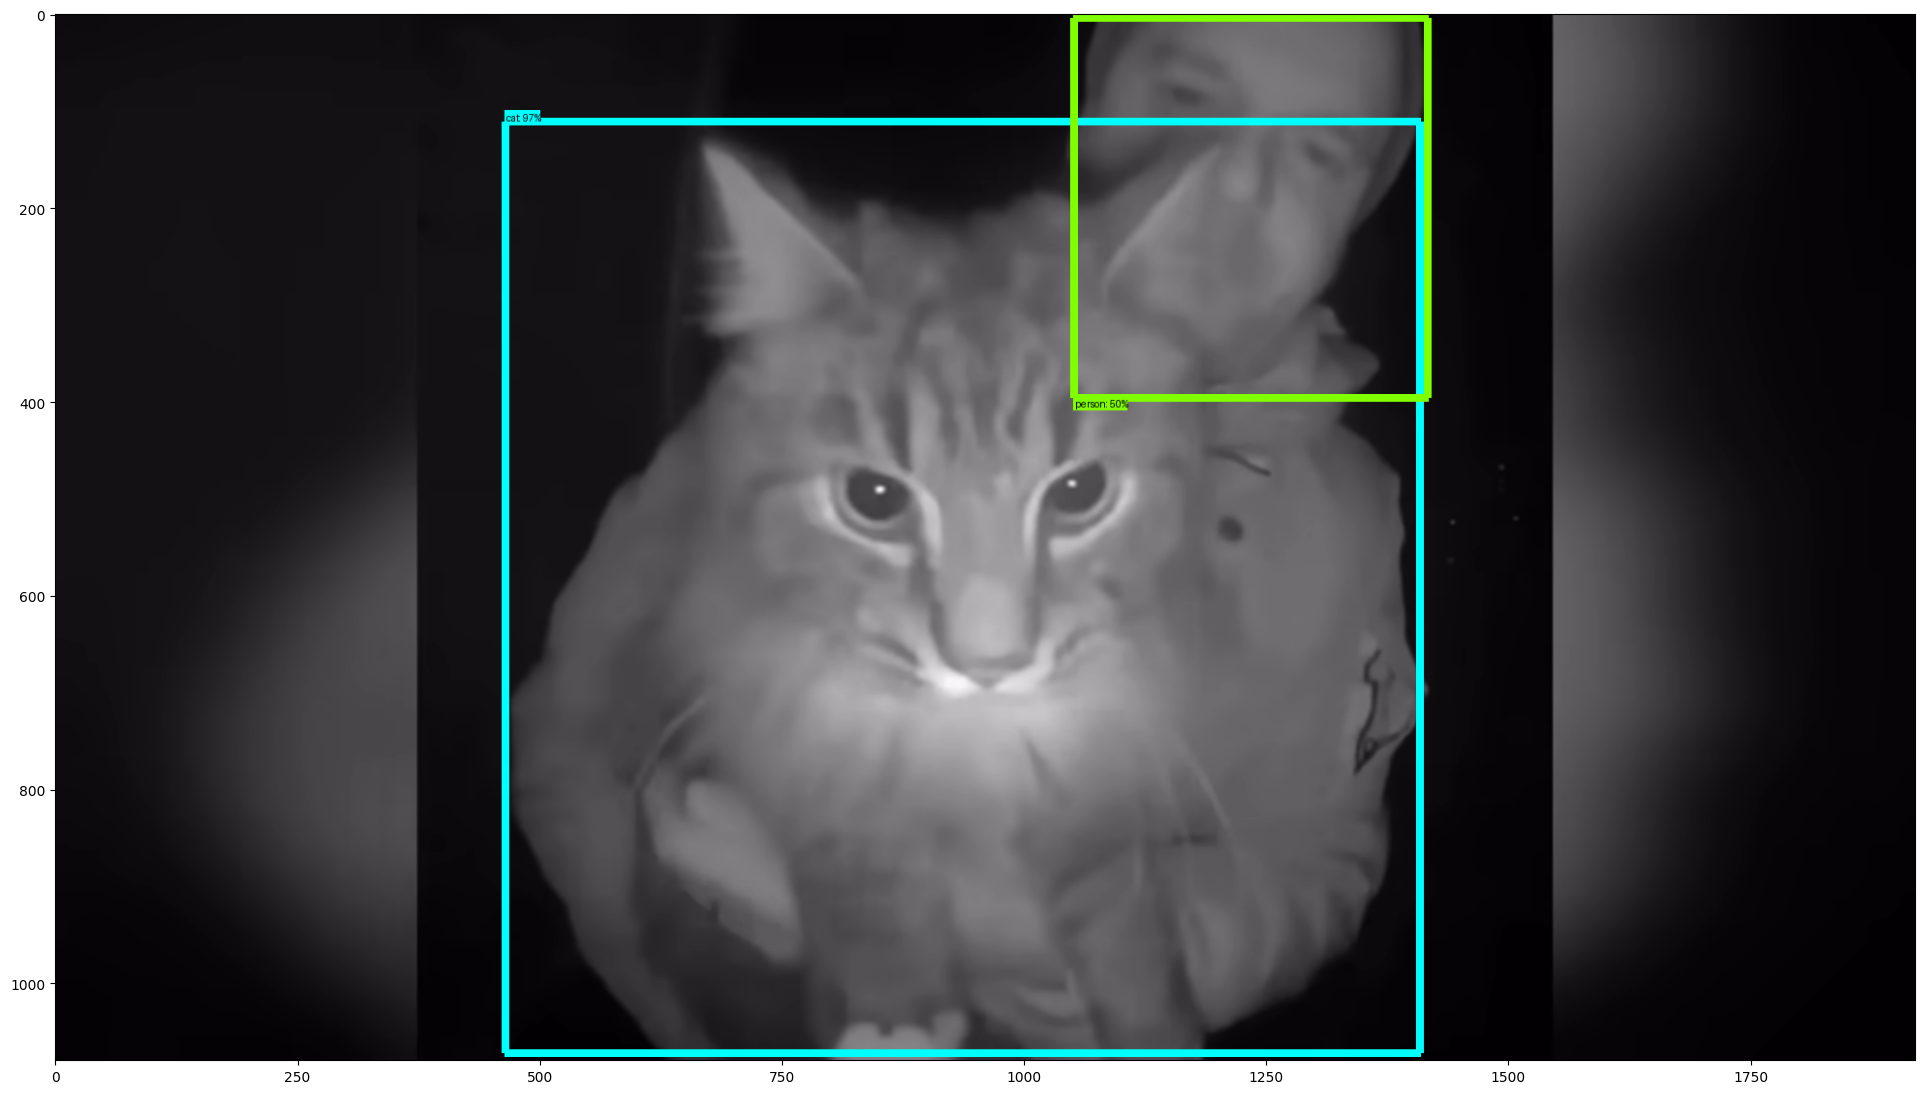

In [34]:
# Handle models with masks:
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:
  # we need to convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # Reframe the bbox mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                      tf.uint8)
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

#count above 0.75
acc=0.75
count_no={}
j=0
for i in (result['detection_classes'][0] + label_id_offset).astype(int):
    if result['detection_scores'][0][j]>=acc:
        #print(f" {category_index[i]['name']} {result['detection_scores'][0][j]}")
        count_no[category_index[i]['name']]=0
    j=j+1


#get
j=0
for i in (result['detection_classes'][0] + label_id_offset).astype(int):
    if result['detection_scores'][0][j]>=acc:
        count_no[category_index[i]['name']]=count_no[category_index[i]['name']]+1
        #print(f" {category_index[i]['name']} {result['detection_scores'][0][j]}")
    j=j+1

print(count_no)


plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()




In [30]:
#count above 0.75
acc=0.75
count_no={}
j=0
for i in (result['detection_classes'][0] + label_id_offset).astype(int):
    if result['detection_scores'][0][j]>=acc:
        #print(f" {category_index[i]['name']} {result['detection_scores'][0][j]}")
        count_no[category_index[i]['name']]=0
    j=j+1


#get
j=0
for i in (result['detection_classes'][0] + label_id_offset).astype(int):
    if result['detection_scores'][0][j]>=acc:
        count_no[category_index[i]['name']]=count_no[category_index[i]['name']]+1
        #print(f" {category_index[i]['name']} {result['detection_scores'][0][j]}")
    j=j+1

print(count_no)

{'kite': 1, 'person': 1}


In [21]:
#hub_model

In [22]:
for i in category_index.keys():
    print(category_index[i]['name'])

person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
couch
potted plant
bed
dining table
toilet
tv
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush


In [23]:
import csv
def object_detect(in_path,in_model,count_no):
    selected_image = in_path
    flip_image_horizontally = False
    convert_image_to_grayscale = False

    image_path = IMAGES_FOR_TEST[selected_image]
    image_np = load_image_into_numpy_array(image_path)

    # Flip horizontally
    if(flip_image_horizontally):
      image_np[0] = np.fliplr(image_np[0]).copy()

    # Convert image to grayscale
    if(convert_image_to_grayscale):
      image_np[0] = np.tile(
        np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # running inference
    results = in_model(image_np)

    # different object detection models have additional results
    # all of them are explained in the documentation
    result = {key:value.numpy() for key,value in results.items()}
    print(result.keys())

    #count object above acc=0.75
    acc=0.75
    #get count of objects detected
    j=0
    for i in (result['detection_classes'][0] + label_id_offset).astype(int):
        if result['detection_scores'][0][j]>=acc:
            count_no[category_index[i]['name']]=count_no[category_index[i]['name']]+1
            #print(f" {category_index[i]['name']} {result['detection_scores'][0][j]}")
        j=j+1

    return count_no

def object_category_index():
    print('Inside object_category_index') #Debugging
    #setting all category to zero
    try:
      PATH_TO_LABELS = f'{config.project_home}/server/.models/research/object_detection/data/mscoco_label_map.pbtxt'
    except:
      PATH_TO_LABELS = f'{project_home}/server/.models/research/object_detection/data/mscoco_label_map.pbtxt'
    category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
    count_no={}
    j=0
    for i in category_index:
        #print(f" {category_index[i]['name']} {result['detection_scores'][0][j]}")
        count_no[category_index[i]['name']]=0
        j=j+1
    return count_no


    
def write_to_csv(in_path,count_no):
# Writing to CSV file
  with open(in_path, 'w', newline='') as csvfile:
    fieldnames = count_no.keys()
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(count_no)
    print(f"Dictionary saved to {csv_file}")


In [24]:
write_to_csv(f"./.screenshots/my_csv.csv",dict({"a":"test"}))

AttributeError: 'str' object has no attribute 'keys'

In [ ]:
def write_to_csv(in_path,count_no):
    csv_filename = "my_csv.csv"
    
    # Define the field names (headers)
    fieldnames = ["Brand", "Model", "Year"]
    
    # Writing to CSV
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()  # Write header row
        writer.writerows(count_no)  # Write data rows

In [ ]:
write_to_csv(f"./.screenshots/my_csv.csv",dict({"Brand":"as", "Model":"ads", "Year":"asdsad"}))

In [ ]:
# Function to load image
def load_image(img_path):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Function to load labels (annotations)
def load_labels(annotation_path):
    import xml.etree.ElementTree as ET
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    labels = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        labels.append([xmin, ymin, xmax, ymax])
    return labels

# Load a few images and labels
image_paths = list(image_dir.glob('*.jpg'))[:5]  # Use first 5 images
images = [load_image(img_path) for img_path in image_paths]
annotations = [load_labels(annotation_dir / (img_path.stem + '.xml')) for img_path in image_paths]

# Function to detect objects
def detect_objects(model, img):
    results = model(img)
    return results

# Perform detection on loaded images
detections = [detect_objects(model, img).pred[0].numpy() for img in images]

# Print sample detection and annotation
print("Sample Detection:", detections[0])
print("Sample Annotation:", annotations[0])

# Function to compute IoU
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

# Function to compute precision, recall, F1 score, and IoU
def compute_metrics(detections, annotations, iou_threshold=0.5):
    y_true = []
    y_pred = []

    for det, ann in zip(detections, annotations):
        detected = [False] * len(det)
        true_positive = 0
        false_positive = 0
        false_negative = len(ann)

        for a in ann:
            matched = False
            for d in det:
                iou = compute_iou(d[:4], a)
                if iou >= iou_threshold:
                    matched = True
                    break
            if matched:
                true_positive += 1
                false_negative -= 1
            else:
                false_positive += 1

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / len(ann) if len(ann) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        y_true.extend([1] * len(ann) + [0] * false_positive)
        y_pred.extend([1] * true_positive + [0] * (false_positive + false_negative))

    precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    return precision_avg, recall_avg, f1_score_avg



In [ ]:
# Calculate mAP
mAP = compute_map(detections, annotations)
print(f"Mean Average Precision (mAP): {mAP:.4f}")

# Calculate precision, recall, and F1 score
precision, recall, f1_score = compute_metrics(detections, annotations)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")